In [1]:
#!pip install librosa

In [40]:
import librosa, matplotlib.pyplot as plt, warnings, numpy as np
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 18})

# Чтение файлов со звуком

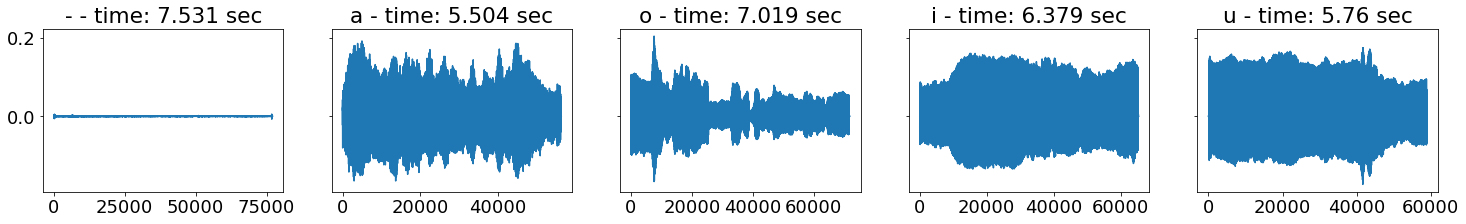

In [41]:
sample_rate = 10240
raw = {}
letterset = '-aoiu'

f, ax = plt.subplots(1, 5, sharey=True, figsize=(25,3))
for i, letter in enumerate(letterset):
    data, sample_rate = librosa.load(f'data/{letter}.m4a', sr=sample_rate)
    raw[letter] = data
    ax[i].set_title(f"{letter} - time: {data.shape[0] / sample_rate:.4} sec")
    ax[i].plot(data)
plt.show()

In [42]:
ms10 = int(sample_rate * .01)
ms100 = int(sample_rate * .1)
print(f"10 ms = {ms10} ticks; 100 ms = {ms100} ticks")

def cook_data(sample, label):
    dataset, target = [], []
    for offset in range(0, sample.shape[0], ms10):
        row = sample[offset:offset + ms100]
        if row.shape[0] < ms100: break
        dataset.append(row)
        target.append(label)
    return dataset, target

10 ms = 102 ticks; 100 ms = 1024 ticks


In [43]:
dataset, target, splits = [], [], [0]
for i, letter in enumerate(letterset):
    d, t = cook_data(raw[letter], i)
    dataset += d
    target += t
    splits.append(len(target))
print("Dataset size:", len(dataset))

Dataset size: 3184


# Быстрое преобразование Фурье

Восприятие звука (из биологических интуиций) имеет частотную природу. Это значит, что прежде чем что-то делать с сигналом, его нужно привести к частотному представлению. Самый разумный подход -- выполнить быстрое преобразование Фурье (алгоритм для вычислений дискретного преобразования), который сигнал из $N$ отсчётов превратит в $N$ часотных компонент.

Для дальнейшего использования в моделях машинного обучения нам будет удобно воспользоваться действительными числами, поэтому мы возьмём ампилитуду сигнала, но не будем брать фазу.

Этот подход имеет вычислительную сложность $\mathcal{O}(n\log n)$.

In [44]:
from scipy.fft import fft

fft_dataset = []
for row in dataset:
    fft_dataset.append(abs(fft(row)))
    
fft_dataset = np.array(fft_dataset)

# Понижение размерности

Частотные данные избыточны по изменениям (у нас 1024 частотных компонент, и всего 3128 примеров). Также понятно, что близкие частоты будут группироваться. Поэтому понизим размерность одним из очевидных методов.

Components: 32


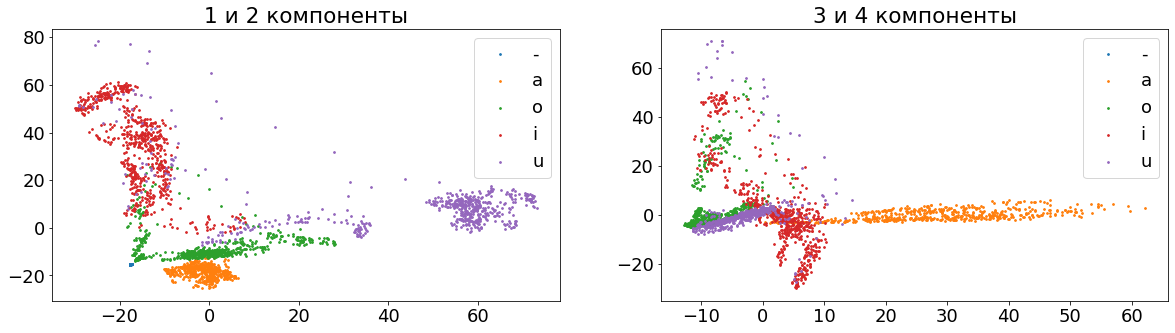

In [45]:
from sklearn.decomposition import PCA

# оставим 99% дисперсии
pca = PCA(n_components=0.99)
reduced_dataset = pca.fit_transform(fft_dataset)
print("Components:", pca.n_components_)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
for i in range(len(splits) - 1):
    ax1.set_title("1 и 2 компоненты")
    ax1.scatter(reduced_dataset[splits[i]:splits[i+1], 0], reduced_dataset[splits[i]:splits[i+1], 1], label=letterset[i], s=3)
ax1.legend()

for i in range(len(splits) - 1):
    ax2.set_title("3 и 4 компоненты")
    ax2.scatter(reduced_dataset[splits[i]:splits[i+1], 2], reduced_dataset[splits[i]:splits[i+1], 3], label=letterset[i], s=3)
ax2.legend()
plt.show()

# Обучим маленькую нейронную сеть различать звуки на половине исходных данных

In [46]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(pca.n_components_,), activation='logistic', max_iter=1000)

trainX, testX = reduced_dataset[::2], reduced_dataset[1::2]
trainY, testY = target[::2], target[1::2]
clf.fit(trainX, trainY)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

# Проверим качество модели на второй половине данных

In [47]:
predictions = clf.predict(testX)
from sklearn.metrics import classification_report
print(classification_report(testY, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       373
           1       1.00      1.00      1.00       271
           2       1.00      0.99      1.00       348
           3       1.00      1.00      1.00       315
           4       1.00      1.00      1.00       285

    accuracy                           1.00      1592
   macro avg       1.00      1.00      1.00      1592
weighted avg       1.00      1.00      1.00      1592



# И, наконец, посмотрим на график предсказаний для файла-примера

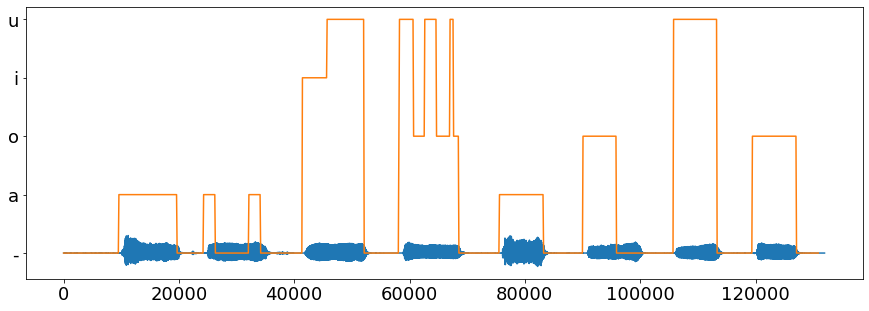

In [54]:
from scipy.signal import medfilt
data, sample_rate = librosa.load(f'data/test.m4a', sr=sample_rate)

X, y = cook_data(data, 'x')
ffted = []
for row in X:
    ffted.append(abs(fft(row)))
ffted = np.array(ffted)
Xpca = pca.transform(ffted)
predictions = clf.predict(Xpca)

plt.figure(figsize=(15, 5))
plt.yticks(range(len(letterset)), letterset)
plt.plot(data)
plt.plot([i * ms10 for i in range(len(predictions))], medfilt(predictions, kernel_size=[15]))
plt.show()

# Соберём решение в одном месте

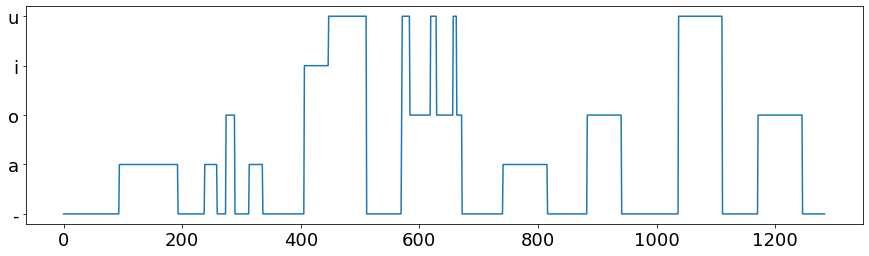

In [4]:
import librosa, matplotlib.pyplot as plt, warnings, numpy as np
from scipy.fft import fft
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from scipy.signal import medfilt
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 18})

sample_rate = 10240
raw = {}
letterset = '-aoiu'
ms10 = int(sample_rate * .01)
ms100 = int(sample_rate * .1)

def fft_proxy(data):
    return abs(fft(data))

def train():
    dataset, target = [], []
    for i, letter in enumerate(letterset):
        sample, _ = librosa.load(f'data/{letter}.m4a', sr=sample_rate)
        for offset in range(0, sample.shape[0], ms10):
            row = sample[offset:offset + ms100]
            if row.shape[0] < ms100: break
            fft_row = abs(fft_proxy(row))
            dataset.append(fft_row)
            target.append(i)
    pca = PCA(n_components=0.99)
    reduced_dataset = pca.fit_transform(dataset)
    clf = MLPClassifier(hidden_layer_sizes=(pca.n_components_,), activation='logistic', max_iter=1000)
    clf.fit(reduced_dataset, target)
    return pca, clf


def predict(raw, pca, ann):
    f = fft_proxy(raw)
    p = pca.transform([f])
    a = ann.predict(p)
    return a[0]


def process_file(filename, pca, ann):
    result = []
    data, _ = librosa.load(filename, sr=sample_rate)
    for offset in range(0, data.shape[0], ms10):
        row = data[offset:offset + ms100]
        if row.shape[0] < ms100: break
        result.append(predict(row, pca, ann))
    return medfilt(result, kernel_size=[15])


pca, ann = train()
pred = process_file('data/test.m4a', pca, ann)


plt.figure(figsize=(15, 4))
plt.yticks(range(len(letterset)), letterset)
plt.plot(pred)
plt.show()

In [ ]:
!pip install qiskit
!pip install pylatexenc

In [121]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

# Соберём квантовый контур, выполняющий преобразование Фурье

https://en.wikipedia.org/wiki/Quantum_logic_gate#Controlled_phase_shift

In [8]:
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1         # Indexes start from 0
    circuit.h(n)   # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(pi/2**(n-qubit), qubit, n)
    qft_rotations(circuit, n)
        
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

Проверим гипотезу. Если изменить состояние одного (среднего) кубита с $|0>$ на $|1>$, а остальных на $|+>$ то это для случая из 3 кубитов эквивалетно:

$\frac{1}{2}(|010> + |011> +|110> +|111>) = \frac{1}{2}(|\tilde{2}> + |\tilde{3}> +|\tilde{6}> +|\tilde{7}>)$

Что является периодическим сигналом ([меандром](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D0%B0%D0%BD%D0%B4%D1%80_(%D1%80%D0%B0%D0%B4%D0%B8%D0%BE%D1%82%D0%B5%D1%85%D0%BD%D0%B8%D0%BA%D0%B0))), а значит в разложении Фурье мы получим чёткие пики по амплитуде.

Если бы зафиксируем старшие кубиты, то получим более редкие колебания. Сделаем это для 7 кубита из 10.

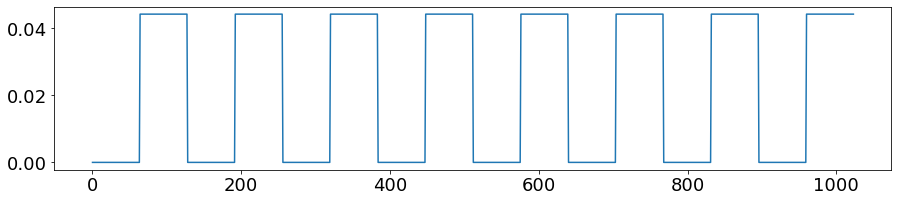

In [132]:
from math import pi
import math
import cmath

qc = QuantumCircuit(10)

qc.h(qc.qubits[0:6])
qc.h(qc.qubits[7:])
qc.x(qc.qubits[6])

sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
result = sv_sim.run(qobj).result()
before_start = abs(result.get_statevector())
plt.figure(figsize=(15, 3))
plt.plot(before_start)
plt.show()


qft_rotations(qc, 10)
swap_registers(qc, 10)

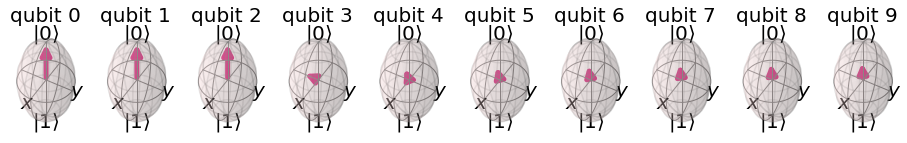

In [133]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
result = sv_sim.run(qobj).result()
statevector = result.get_statevector()
plot_bloch_multivector(statevector)

Вероятности получения состояния - это квадраты ампилтуд разложения. Поэтому чтобы получить аналогичные результаты, извлечём корень.

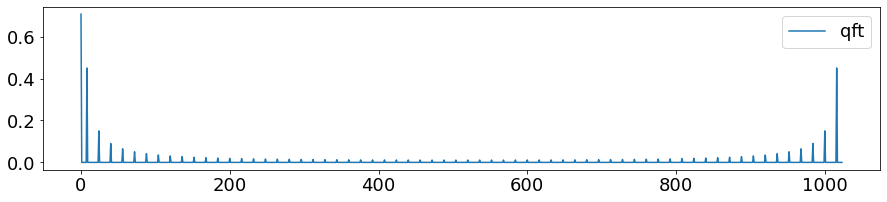

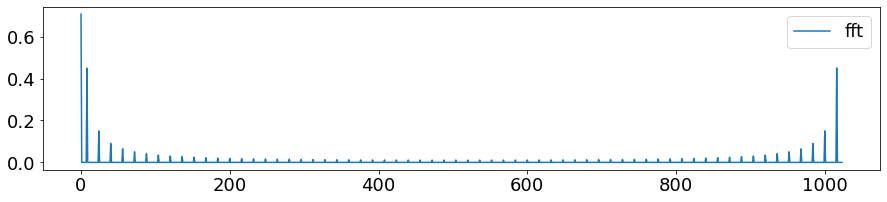

0 0.5
8 0.202683062291597
1016 0.202683062291597
24 0.02255655284992
1000 0.02255655284992


In [134]:
result = sv_sim.run(qobj).result()
counts = result.get_counts()


data = [0] * 1024
for key in counts:
    data[int(key, 2)] = (counts[key]) ** .5

plt.figure(figsize=(15, 3))
plt.plot(data, label='qft')
plt.legend()
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(abs(fft(before_start) / (1024 ** .5)), label="fft")
plt.legend()
plt.show()

from collections import Counter
for k, v in Counter(counts).most_common(5):
    print(int(k, 2), v)

# повторим этот же результат для вероятностного симулятора

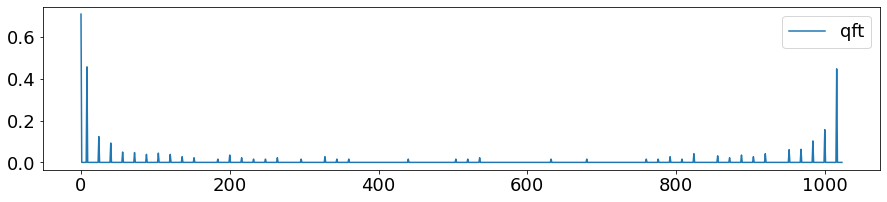

In [138]:
qc.measure_all()

shots = 4096
job = execute(qc,Aer.get_backend('qasm_simulator'), shots=shots)
counts = job.result().get_counts(qc)
data = [0] * 1024
for key in counts:
    for kkey in key.split():
        data[int(kkey, 2)] = (counts[key] / shots) ** .5

plt.figure(figsize=(15, 3))
plt.plot(data, label='qft')
plt.legend()
plt.show()

Воспользуемся методом initialize, чтобы проинициализировать амплитуды в нужные нам значения. [Обратимся к документации](https://qiskit.org/documentation/locale/de_DE/_modules/qiskit/extensions/quantum_initializer/initializer.html):
```
Initialize is an Instruction and not a Gate since it contains a reset instruction.
```

Инициализация обсуждается в статье https://arxiv.org/abs/quant-ph/0406176v5. Там утверждается, что время построение произвольного состояния имеет порядок $\mathcal{O}(4^q)$ или $\mathcal{O}(4^{log_2(n)}) = \mathcal{O}(n^2)$. Это сопоставимо со временем DFT.

In [172]:
import math

def qft(row):
    # нормируем коэффициенты
    row = row.astype(np.float64)
    row = row  / sum(np.absolute(row) ** 2) ** .5
    qc = QuantumCircuit(10)
    qc.initialize(row, qc.qubits)
    qft_rotations(qc, 10)
    swap_registers(qc, 10)
    qc.measure_all()
    job = execute(qc,Aer.get_backend('qasm_simulator'), shots=4096)
    counts = job.result().get_counts(qc)
    data = np.zeros((len(row),))
    for key in counts:
        for kkey in key.split():
            data[int(kkey, 2)] = (counts[key] / 4096) ** .5
    return data

- https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html
- https://qiskit.org/documentation/stubs/qiskit.circuit.library.QFT.html
- https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

In [ ]:
import librosa, matplotlib.pyplot as plt, warnings, numpy as np, math
from scipy.fft import fft
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from scipy.signal import medfilt

from qiskit import QuantumCircuit, Aer, execute
from tqdm import tqdm

warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 18})

sample_rate = 10240
raw = {}
letterset = '-aoiu'
ms10 = int(sample_rate * .01)
ms100 = int(sample_rate * .1)

def fft_proxy(data):
    return qft(data)

def train():
    dataset, target = [], []
    for i, letter in enumerate(letterset):
        sample, _ = librosa.load(f'data/{letter}.m4a', sr=sample_rate)
        print(f'Processing data/{letter}.m4a')
        for offset in tqdm(range(0, sample.shape[0], ms10)):
            row = sample[offset:offset + ms100]
            if row.shape[0] < ms100: break
            fft_row = abs(fft_proxy(row))
            dataset.append(fft_row)
            target.append(i)
    pca = PCA(n_components=0.99)
    reduced_dataset = pca.fit_transform(dataset)
    clf = MLPClassifier(hidden_layer_sizes=(pca.n_components_,), activation='logistic', max_iter=1000)
    clf.fit(reduced_dataset, target)
    return pca, clf


def predict(raw, pca, ann):
    f = fft_proxy(raw)
    p = pca.transform([f])
    a = ann.predict(p)
    return a[0]


def process_file(filename, pca, ann):
    print("Processing a file", filename)
    result = []
    data, _ = librosa.load(filename, sr=sample_rate)
    for offset in tqdm(range(0, data.shape[0], ms10)):
        row = data[offset:offset + ms100]
        if row.shape[0] < ms100: break
        result.append(predict(row, pca, ann))
    return medfilt(result, kernel_size=[15])


pca, ann = train()
pred = process_file('data/test.m4a', pca, ann)


plt.figure(figsize=(15, 4))
plt.yticks(range(len(letterset)), letterset)
plt.plot(pred)
plt.show()

  0%|          | 0/757 [00:00<?, ?it/s]

Processing data/-.m4a


 27%|██▋       | 201/757 [04:38<10:52,  1.17s/it]